In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate as integ
from scipy.special import hyp2f1
from scipy.interpolate import CubicSpline
import math
from scipy.interpolate import interp1d
import imf.imf as imf #URL https://github.com/keflavich/imf
from scipy.optimize import curve_fit
from matplotlib import cm
%config InlineBackend.figure_format = 'retina' #for higher res plots in jupyter 
from scipy.special import erf
import json
import scipy
from descartes import PolygonPatch
from shapely.geometry import Polygon, Point
import os
from scipy.spatial.distance import pdist as pdist
Names = ['BootesI','BootesII','BootesIII','Coma','Crater','CanesI','CanesII','Draco','DracoII','Hercules','LeoI','LeoII','LeoIV','LeoV',\
    'PiscesII','SagII','SegueI','SegueII','SextansI','TriII','UrsaMajorI','UrsaMajorII','UrsaMinor','WillmanI','CetusII','ColumbaI',\
    'EridanusIII','Fornax','GrusI','GrusII','HoroI','HoroII','PhoenixII','PictorI','RetiII','RetiIII','TucanaII','TucanaIII','TucanaIV','TucanaV']

dsph_d = json.load(open("40dSphDict.json"))





In [4]:
"""
Distributions and their integrals
"""

def Plummer(r,a):
    ans = 1/(math.pi*a**2) * 1/((1+(r/a)**2)**2)
    return(ans)

def SPLtrunc(s,g1,sb):
    ans = s**g1 * np.heaviside(sb-s,0.5)
    return(ans)

def SPLtruncint(smin,smax,sb):
    if smax>sb:
        ans = 2/3 * sb**(3/2)
    else: 
        ans = 2/3 * smax**(3/2)
    ans = ans - 2/3*smin**(3/2)
    return(ans)

def OpikInt(smin,smax):
    ans = np.log(smax/smin)
    return(ans)

def BPL(s,g1,g2,sb,L):
    ans = (s/sb)**g1 * (0.5*(1+(s/sb)**(1/L)))**((g2-g1)*L)
    return(ans)

def BPLIntegral(smin,smax,g1,g2,sb,L): 
    hyp1 = hyp2f1((1+g1)*L,(g1-g2)*L,1+L+g1*L,-(smax/sb)**((1/L)))
    #print(hyp1)
    hyp2 = hyp2f1((1+g1)*L,(g1-g2)*L,1+L+g1*L,-(smin/sb)**((1/L)))
    #print(hyp2)
    c0 = (1/(1+g1))*(0.5**((-g1+g2)*L)) 
    c1 = smax*((smax/sb)**g1) 
    #print(c1)
    c2 = smin*(smin/sb)**g1
    #print(c2)
    ans = c0*(c1*hyp1 - c2*hyp2)
    return(ans)

In [5]:
"""
xy-position samplers
"""

def GetPlummer(a,numStars):
    I0 = numStars/(math.pi*a**2)
    Narr = np.random.uniform(0,1,size=numStars)
    rarr = a*np.sqrt(Narr/(1-Narr))    
    return(rarr)

def RtoXY(rarr):
    x = np.zeros(len(rarr))
    y = np.zeros(len(rarr))
    for i in range(len(rarr)):
        theta = np.random.uniform(0,2*math.pi)
        x[i] = rarr[i]*np.sin(theta)
        y[i] = rarr[i]*np.cos(theta)
    return(x,y)

def RandomUniform(rmax,N):
    length = np.random.uniform(0,1,N)
    angle = 2*math.pi*np.random.uniform(0, 1,N)

    x = rmax*np.sqrt(length) * np.cos(angle)
    y = rmax*np.sqrt(length) * np.sin(angle)
    return(x,y)

In [6]:
"""
Binary separation samplers
"""

def sample_BPL_binaries(g1,g2,sb,L, pnts, s_min, s_max, n=1e5, plot=False):
    s = np.linspace(s_min, s_max, int(n))
    cumulative = np.cumsum(BPL(s,g1,g2,sb,L))
    cumulative -= cumulative.min()
    f = interp1d(cumulative/cumulative.max(), s)
    seps = f(np.random.random(pnts))
    if plot==True:
        bins = np.logspace(np.log10(0.8*s_min),np.log10(1.2*s_max),50)
        c,b,p = plt.hist(seps,bins=bins,histtype='step',density=True)
        bplnorm = BPLIntegral(s_min,s_max,g1,g2,sb,L)
        plt.plot(bins,BPL(bins,g1,g2,sb,L)/bplnorm)
        plt.xscale('log')
        plt.yscale('log')
        plt.vlines(sb,min(c[c!=0]),max(c[c!=0]))
        plt.vlines(s_min,min(c[c!=0]),max(c[c!=0]))
        plt.vlines(s_max,min(c[c!=0]),max(c[c!=0]))
        plt.show()
        
    return f(np.random.random(pnts))   


def sample_Trunc_binaries(g1,g2,sb,L, pnts, s_min, s_max, n=1e5, plot=False):
    s = np.linspace(s_min, sb, int(n))
    cumulative = np.cumsum(s**0.5)
    cumulative -= cumulative.min()
    f = interp1d(cumulative/cumulative.max(), s)
    seps = f(np.random.random(pnts))
    if plot==True:
        bins = np.logspace(np.log10(0.8*s_min),np.log10(1.2*s_max),50)
        c,b,p = plt.hist(seps,bins=bins,histtype='step',density=True)
        truncbins = np.logspace(np.log10(s_min),np.log10(sb),500)
        
        truncnorm = 2/3 * ((sb)**(3/2) - (s_min)**(3/2))
        plt.plot(truncbins,truncbins**(0.5)*np.heaviside(sb-truncbins,0)/truncnorm)
        plt.xscale('log')
        plt.yscale('log')
        plt.vlines(sb,min(c[c!=0]),max(c[c!=0]))
        plt.vlines(s_min,min(c[c!=0]),max(c[c!=0]))
        plt.vlines(s_max,min(c[c!=0]),max(c[c!=0]))
        plt.show()
        
    return f(np.random.random(pnts))   


def sample_Opik_binaries(g1,g2,sb,L, pnts, s_min, s_max, n=1e5, plot=False):
    s = np.linspace(s_min, s_max, int(n))
    cumulative = np.cumsum(s**(-1))
    cumulative -= cumulative.min()
    f = interp1d(cumulative/cumulative.max(), s)
    seps = f(np.random.random(pnts))
    if plot==True:
        bins = np.logspace(np.log10(0.8*s_min),np.log10(1.2*s_max),50)
        c,b,p = plt.hist(seps,bins=bins,histtype='step',density=True)
        opiknorm = OpikInt(s_min,s_max)
        plt.plot(bins,bins**(-1)/opiknorm)
        plt.xscale('log')
        plt.yscale('log')
        plt.vlines(sb,min(c[c!=0]),max(c[c!=0]))
        plt.vlines(s_min,min(c[c!=0]),max(c[c!=0]))
        plt.vlines(s_max,min(c[c!=0]),max(c[c!=0]))
        plt.show()
        
        
    
    return f(np.random.random(pnts))

def Add_Binaries(x,y,bx,by): #Takes parent star xy's and binary separations, returns parent and binary xy's
    if len(x)<len(bx):
        print("More Binaries than Parent Stars - Aborting")
        return(0)
    n = len(x)
    nb = len(bx)
    addx = np.zeros(len(bx))
    addy = np.zeros(len(by))
    for i in range(0,len(bx)):
        addx[i] = x[i] + bx[i]
        addy[i] = y[i] + by[i]
    return(np.append(x,addx),np.append(y,addy))



    

In [7]:
"""
Interpolator definitions 
"""

def Interps(IMF,mass,lum,Vmag): #Interpolates Initial Mass Function with mass/mags/lums
    massinterp = CubicSpline((IMF),(mass))
    luminterp = CubicSpline((IMF),(lum))
    Vmaginterp = CubicSpline((IMF),(Vmag))
    return(massinterp,luminterp,Vmaginterp)

def MakeMonotonic(isovmagbin):
    ismono = np.zeros(len(isovmagbin)-1)
    while(np.sum(ismono)<len(ismono)):
        for i in range(0,len(isovmagbin)-1):
            if(isovmagbin[i+1]-isovmagbin[i] <= 0.0):
                isovmagbin[i+1] = (isovmagbin[i] + isovmagbin[i+2])/2
            else:
                ismono[i] = 1
    return(isovmagbin)

In [8]:
"""
Magnitude Cuts
"""

def MagnitudeCut(pmags,bmags,maglim): #Cuts both parent and binaries by magnitude, and determines how many binary pairs remain detectable
    NP = len(pmags)
    NB = len(bmags)
    becomesPlum = np.zeros(NB)
    survives = np.zeros(NB)
    for i in range(0,NB):
        parent = int(pmags[i]<maglim)
        binary = int(bmags[i]<maglim)
        if parent==0 and binary==1:
            becomesPlum[i] = 1
        if (parent + binary)==2:
            survives[i] = 1
    plumsurv = pmags[pmags<maglim]
    newplums = bmags[becomesPlum==1]
    binsurv = bmags[survives==1]
    totplum = np.append(plumsurv,newplums)
    newPlumNum = len(totplum)
    newBinNum = len(binsurv)
    return(totplum,binsurv,newPlumNum,newBinNum)

In [9]:
"""
Polygon Cutter
"""

def PolyCheck(SUMPOLY,x,y):
    res= False
    xy = np.transpose(np.array([x,y]))
    if Point(xy).within(SUMPOLY):
        res = True
    return(res)

def Cutter(x,y,poly,nri,nbi):
    goods = np.zeros(len(x))
    for i in range(0,len(x)):
        goods[i] = PolyCheck(poly,x[i],y[i]) #returns True (aka 1) if xy is inside the polygon
    nrf = np.sum(goods[:nri])
    nbf = np.sum(goods[nri:])
    cx = x[goods==1]
    cy = y[goods==1]
    #print(np.sum(goods))
    return(cx,cy,nrf,nbf)

In [10]:
"""
The workhorse function. Populates xy-positions of dSph and foreground, both parents and binaries, after magnitude cuts in the dSph.
"""


def GetSamples(fn,fnum,d,maglim=27,binarymode='clumpy',Nslim=10000000,plot=True,verbose=True):

    if verbose==True:
        print("Populating " + fn)
    
    """
    Get dSph Parameters from dictionary; _pc denotes units of parsecs, _am units of arcminutes
    """
    dis_pc = d[fn]['Distance']*1000
    smin_am = 0.05/60 #Resolution limit of 0.05 arcseconds
    smax_am = 2.0/(dis_pc) * 360/(2*math.pi) * 60
    a_pc = d[fn]['Rp']
    a_am = a_pc/dis_pc * 360/(2*math.pi) * 60
    print(a_am)
    rmax = 10*a_am    #This is usually my maximum field radius for the uniform stars. Can be altered.
    ecc = d[fn]['e']
    elipa = a_am/(np.sqrt(1-ecc))
    elrot = 0#52/360*2*math.pi #degrees to radians, degrees input manually.
    elipb = elipa * np.sqrt(1-ecc**2)
    elipa = elipa/a_am
    elipb = elipb/a_am
    
    
    
    
    if verbose==True:
        print("Sampling dSph")  
        
        
        
    #These have been computed elsewhere from luminosities etc
    NPlum = d[fn]["NS"] #Number of stars in dSph before any cuts
    Mtot = d[fn]['MTot'] #Total mass of dSph
    if verbose==True:
        print("Total Number of dSph Parent Stars = " + str(NPlum))
    
    
    """
    Get dSph Binary number
    ______________________
    
    First step is to compute the number of binaries above the resolution/mag limits. This is done assuming the following:
    1: We assume a 10% binary fraction in the dSph, which follows a smooth broken power law from s = 0 to s = 2pc//
        which is our upper cutoff on binary separations.
    2: We compute what percentage of those binaries would fall above our resolution limit
    3: We multiply this number by 'plummagfrac', the number of stars which survived our magnitude cut.//
        This accounts for the fact that both a binary and its companion must both individually survive the //
        magnitude cut.
    4: The number of smooth BPL binaries is then this number multiplied by NPMC, the number of Plummer stars which//
        survived the mag cut.
    5: For the truncated power law, we assume that they originated as the above smooth BPL, and that all binaries//
        above the truncation have been removed. So this number of binaries will be less than that of the smooth BPL
    6: For Öpik's law, we assume the number of binaries with separations above the break separation is the //
        same as that of the smooth BPL, and compute the total number accordingly
    """
        
    
    raw_binary_fraction = 0.1 
    sbp_am = 0.5/(dis_pc) * 360/(2*math.pi) * 60 #Break Separation, 0.5 parsecs in arcminutes
    
    NPB_BPL = int(raw_binary_fraction*NPlum*BPLIntegral(smin_am,smax_am,0.5,-1.0,sbp_am,0.5)/BPLIntegral(0,smax_am,0.5,-1.0,sbp_am,0.5))
    NPB_Trunc = int(NPB_BPL*BPLIntegral(smin_am,sbp_am,0.5,-1.0,sbp_am,0.5)/BPLIntegral(smin_am,sbp_am,0.5,-1.0,sbp_am,0.5))
    NPB_Opik = int(NPB_BPL * BPLIntegral(sbp_am,smax_am,0.5,-1.0,sbp_am,0.5)/BPLIntegral(smin_am,smax_am,0.5,-1.0,sbp_am,0.5)*OpikInt(smin_am,smax_am)/OpikInt(sbp_am,smax_am))
    if binarymode=='clumpy':
        NPB = NPB_BPL
    if binarymode=='trunc':
        NPB = NPB_Trunc
    if binarymode=='opik':
        NPB = NPB_Opik
    
    
    if verbose==True:
        print("Total Number of dSph Binary Stars = " + str(NPB))    
    
    """
    Sampling the magnitudes;
    Relationship between initial mass function and magnitudes/luminosites is interpolated
    Initial masses then populated via https://github.com/keflavich/imf
    Mags/Lums then sampled from those
    """
    
    if verbose==True:
        print("Sampling dSph Magnitudes")
    
    
    #Load parameters from Isochrone (Will have to change indices if using different filters etc)
    isofile = np.genfromtxt("LumFuncs/"+fn+"-J.txt")
    label = isofile[:,9]
    labelcut=4 #Cut everything except pre-main-sequence, main-sequence, subgiant and red giant phases.
    mini = isofile[:,3][label<labelcut] #Initial Mass
    mass = isofile[:,5][label<labelcut] #Mass
    lum = isofile[:,6][label<labelcut] #Luminosity
    Vmag = isofile[:,28][label<labelcut] #V-band Magnitude
    mini = MakeMonotonic(mini)   #Can only be sampled if the input is monotonic. Seometimes randomly isn't.
    (massinterp,luminterp,Vmaginterp) = Interps(mini,mass,lum,Vmag) #Function for creating simple spline interpolations
    
    
    
    #Make Parent IMF sampling
    #5*Mtot ensures we still have Ntot stars after mass in (mini) cut
    parentsamples = imf.make_cluster(5*Mtot,silent=True)
    parentpsamples = parentsamples[parentsamples>min(mini)]
    parentpsamples = parentpsamples[parentpsamples<max(mini)]
    #Check that we still have at least Ns stars after the mini cut, and then reduce the array to only Ns stars
    if len(parentpsamples)<NPlum:
        raise Exception('Number Samples < NPlum')
    parentfsamples = np.random.choice(parentpsamples,NPlum)
    #Interpolate the mass, luminosity and magnitude functions

    parentsampledmasses = massinterp(parentfsamples)
    parentsampledlums = luminterp(parentfsamples)
    parentsampledVmags = Vmaginterp(parentfsamples)

    #Convert Vmag to apparent magnitude for mag cuts
    parentsampledappmag = parentsampledVmags + 5*np.log10(d[fn]['Distance']*1000) - 5
    
    
    
    
    #Make Binary IMF sampling, same procedure as above
    binarysamples = imf.make_cluster(5*Mtot,silent=True)
    binarypsamples = binarysamples[binarysamples>min(mini)]
    binarypsamples = binarypsamples[binarypsamples<max(mini)]

    if len(binarypsamples)<NPB:
        raise Exception('Number Samples < NPB')
    binaryfsamples = np.random.choice(binarypsamples,NPB)

    binarysampledmasses = massinterp(binaryfsamples)
    binarysampledlums = luminterp(binaryfsamples)
    binarysampledVmags = Vmaginterp(binaryfsamples)
    binarysampledappmag = binarysampledVmags + 5*np.log10(d[fn]['Distance']*1000) - 5
    
    
    
    
    
    
    """
    Magnitude Cut
    For each binary pair: 
    If parent survives cut, binary doesn't: Nothing happens
    If binary survives cut, parent doesn't: becomes a new parent star
    If both survive cut: remains as a binary pair
    Number of binaries and parent stars will be updated accordingly.
    """
    
    plummags,binmags,NP_MC,NPB_MC = MagnitudeCut(parentsampledappmag,binarysampledappmag,maglim)
    totmags = np.append(plummags,binmags)
    
    if verbose==True:
        print("Number of dSph Parent Stars After Mag Cut = " + str(NP_MC))
        print("Number of dSph Binary Stars After Mag Cut = " + str(NPB_MC)) 
        print("Detectable dSph Binary Fraction = " + str(NPB_MC/NP_MC))
        
    """
    Sample Stellar Positions, by default in units of arcminutes
    """
    if verbose==True:
        print("Sampling dSph Positions")
    #Sample the Plummer Stars
    prs = GetPlummer(a_am,NP_MC)
    tpx,tpy = RtoXY(prs)
    #Make them elliptical and rotate them
    tpx = elipa*tpx
    tpy = tpy*elipb
    px_mc = tpx*np.cos(elrot) - tpy*np.sin(elrot)
    py_mc = tpx*np.sin(elrot) + tpy*np.cos(elrot)
    
    #This is here in case you want to work on a smaller data set: Nslim defaults to 10^7
    if(len(px_mc)>Nslim):
        print("Number of predicted stars was greater than Ns Limit")
        px_mc = px_mc[:Nslim]
        py_mc = py_mc[:Nslim]

    
    
    #Add the binary positions
    if binarymode=='clumpy':
        g1p = 0.5
        g2p = -1.0
        Lp = 0.5
        pbseps = sample_BPL_binaries(g1p,g2p,sbp_am,Lp,NPB_MC,smin_am,smax_am,plot=plot)
        pbx,pby = RtoXY(pbseps)
        pwbx,pwby = Add_Binaries(px_mc,py_mc,pbx,pby)
    if binarymode=='trunc':
        g1p = 0.5
        g2p = -30.0
        sbp_am = 0.5/(dis_pc) * 360/(2*math.pi) * 60 #Break Separation, 0.5 parsecs in arcminutes
        Lp = 0.01
        pbseps = sample_Trunc_binaries(g1p,g2p,sbp_am,Lp,NPB_MC,smin_am,smax_am,plot=plot)
        pbx,pby = RtoXY(pbseps)
        pwbx,pwby = Add_Binaries(px_mc,py_mc,pbx,pby)
    if binarymode=='opik':
        g1p = -1.0
        g2p = -1.0
        sbp_am = 0.5/(dis_pc) * 360/(2*math.pi) * 60 #Break Separation, 0.5 parsecs in arcminutes, doesnt matter here
        Lp = 0.5 #doesnt matter here
        pbseps = sample_Opik_binaries(g1p,g2p,sbp_am,Lp,NPB_MC,smin_am,smax_am,plot=plot)
        pbx,pby = RtoXY(pbseps)
        pwbx,pwby = Add_Binaries(px_mc,py_mc,pbx,pby)

    
    if verbose==True:
        print("Sampling Foreground") 
        
        
        
    if verbose==True:
        print("Sampling Foreground Positions")    
    

    


    #ADD UNIFORM BINARIES
    foreground_binary_fraction  = 0.1
    foreground_fraction = 1.0 #defined as the ratio of foreground stars to dSph stars, here a 1:1 mixture
    FSURV = 0.85745 #This is the percentage of foreground stars which survived the mag cut. //
        #I have no idea where I got this number from...
        #It's necessary for the binary fraction (again, both stars must survive cut)
    
    #Number of uniform stars: assumed that tha above ratio is wrt the number of detectable stars, therefore no mag cuts necessary
    NU_MC = int(np.floor((NP_MC+NPB_MC)*foreground_fraction))
    #Number of Uni
    NUB_MC = int(np.floor(NU_MC*foreground_binary_fraction*FSURV))
    
    
    if verbose==True:
        print("Number of Detectable FG Parent Stars = " + str(NU_MC))    
        print("Number of Detectable FG Binary Stars = " + str(NUB_MC))    
        print("FG Detectable Binary Fraction = " + str(NUB_MC/NU_MC))
    ux,uy = RandomUniform(rmax,NU_MC)
    
      
    g1u = -1.55
    g2u = -3.33
    sbu_am = 0.1/(10*1000) * 360/(2*math.pi) * 60 #assumes an average distance of 10kpc to FG stars
    
    Lu = 0.5
    ubseps = sample_BPL_binaries(g1u,g2u,sbu_am,Lu,NUB_MC,smin_am,smax_am,plot=plot)
    ubx,uby = RtoXY(ubseps)
    uwbx,uwby = Add_Binaries(ux,uy,ubx,uby)

    
    
    

        
    plum_parent_x = pwbx[:NP_MC]   
    plum_parent_y = pwby[:NP_MC]   
    plum_binary_x = pwbx[NP_MC:]   
    plum_binary_y = pwby[NP_MC:]          
    
    uni_parent_x = uwbx[:NU_MC]   
    uni_parent_y = uwby[:NU_MC]   
    uni_binary_x = uwbx[NU_MC:]   
    uni_binary_y = uwby[NU_MC:] 
    
    res_array = [plum_parent_x,plum_parent_y,plum_binary_x,plum_binary_y,uni_parent_x,uni_parent_y,uni_binary_x,uni_binary_y,plummags,binmags,NP_MC,NPB_MC,NU_MC,NUB_MC]
    
    
    
    return(res_array)

In [11]:
"""
Code to run the sampling is in the next block.
Possible values for binarymode are:
'clumpy': Broken Power law with g1=0.5, g2=-1.0
'trunc': Truncated power law with g1 = 0.5
'opik': Öpik's law, g1=g2 = -1.0

Results are placed into a dictionary.
"""

results_dictionary = {}

Populating BootesI
12.34
Sampling dSph
Total Number of dSph Parent Stars = 92143
Total Number of dSph Binary Stars = 9193
Sampling dSph Magnitudes
Number of dSph Parent Stars After Mag Cut = 60442
Number of dSph Binary Stars After Mag Cut = 3702
Detectable dSph Binary Fraction = 0.06124880050296152
Sampling dSph Positions


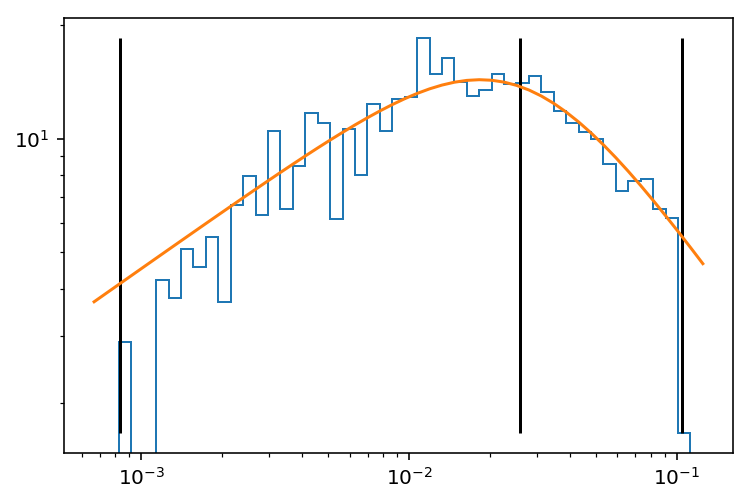

Sampling Foreground
Sampling Foreground Positions
Number of Detectable FG Parent Stars = 64144
Number of Detectable FG Binary Stars = 5500
FG Detectable Binary Fraction = 0.08574457470690945


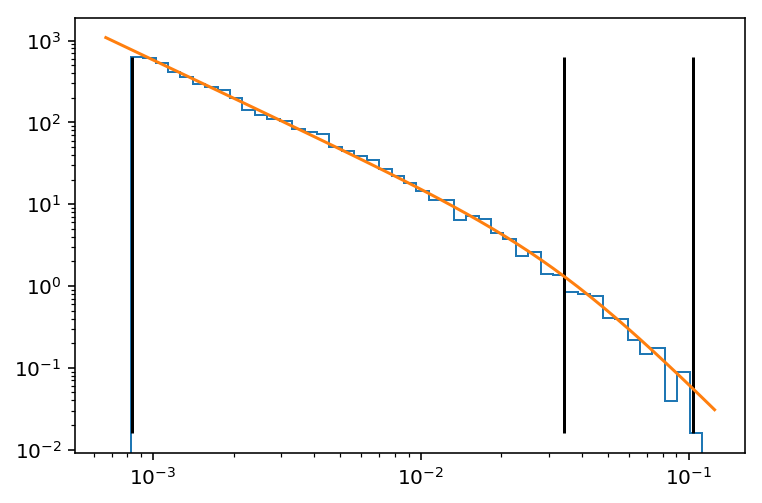

In [12]:

i = 0

#Indent the rest of this block and loop for i in range(0,len(Names)): to do all dSphs

results_dictionary[Names[i]] = {}
result_array = GetSamples(Names[i],i,dsph_d,maglim=27,binarymode='clumpy',Nslim=10000000,plot=True,verbose=True)
#I've done the below one by one so it's clear what the terms are
results_dictionary[Names[i]]['px'] = result_array[0] # dSph Parent x-position
results_dictionary[Names[i]]['py'] = result_array[1] # dSph Parent y-position
results_dictionary[Names[i]]['pbx'] = result_array[2] # dSph Binary x-position
results_dictionary[Names[i]]['pby'] = result_array[3] # dSph Binary y-position
results_dictionary[Names[i]]['ux'] = result_array[4] # FG Parent x-position
results_dictionary[Names[i]]['uy'] = result_array[5] # FG Parent y-position
results_dictionary[Names[i]]['ubx'] = result_array[6] # FG Binary x-position
results_dictionary[Names[i]]['uby'] = result_array[7] # FG Binary y-position
results_dictionary[Names[i]]['p_mags'] = result_array[8] #dSph Parent Magnitudes
results_dictionary[Names[i]]['pb_mags'] = result_array[9] #dSph Binary Magnitudes
results_dictionary[Names[i]]['NP'] = result_array[10] #Number of dSph parents after mag cuts (=len(px)) etc
results_dictionary[Names[i]]['NPB'] = result_array[11] #Number of dSph binaries """"
results_dictionary[Names[i]]['NU'] = result_array[12] ##Number of FG parents """"
results_dictionary[Names[i]]['NUB'] = result_array[13] #Number of FG binaries """"

In [13]:
"""
Below is a quick example of cutting the field, performed on the total dSph xy's and the total FG xy's separately
Might have to adapt the Cutter function if you want to cut the binary populations separately, or cut the total xy's in one go.
^ It currently takes in parenst and binaries, along with the number of each, and returns the number of each after the cut.
It also doesn't cut the magnitudes. I can add that if you need it.
"""

xw = 50 #width of rectangular field
yw = 50 # height of rectangular field


polyxarr = [-xw/2,xw/2,xw/2,-xw/2,-xw/2]
polyyarr = [-yw/2,-yw/2,yw/2,yw/2,-yw/2]
poly = Polygon(np.transpose(np.array([polyxarr,polyyarr])))

i = 0 #Just for purpose of this example

#check that the polygon is within ten halflight radii, otherwise the foregound sampling will be incorrect.
if np.sqrt((xw/2)**2 + (yw/2)**2) > 10*dsph_d[Names[i]]['Rp']/(1000*dsph_d[Names[i]]['Distance']) * 360/(2*math.pi) * 60:
    raise Exception("Proposed field cut is greater than 10 times the halflight radius: foreground stars will not be correctly sampled")




dsphx = np.append(results_dictionary[Names[i]]['px'],results_dictionary[Names[i]]['pbx'])
dsphy = np.append(results_dictionary[Names[i]]['py'],results_dictionary[Names[i]]['pby'])

fgx = np.append(results_dictionary[Names[i]]['ux'],results_dictionary[Names[i]]['ubx'])
fgy = np.append(results_dictionary[Names[i]]['uy'],results_dictionary[Names[i]]['uby'])

dsphcutx,dsphcuty,NP_F,NPB_F = Cutter(dsphx,dsphy,poly,results_dictionary[Names[i]]['NP'],results_dictionary[Names[i]]['NPB'])
fgcutx,fgcuty,NU_F,NUB_F = Cutter(fgx,fgy,poly,results_dictionary[Names[i]]['NU'],results_dictionary[Names[i]]['NUB'])

print("Number of dSph Parents went from " + str(results_dictionary[Names[i]]['NP']) + " to " + str(NP_F))
print("Number of dSph Binaries went from " + str(results_dictionary[Names[i]]['NPB']) + " to " + str(NPB_F))
print("dSph Detectable Binary Fraction went from " + str(results_dictionary[Names[i]]['NPB']/results_dictionary[Names[i]]['NP']) + " to " + str(NPB_F/NP_F))
print("Number of FG Parents went from " + str(results_dictionary[Names[i]]['NU']) + " to " + str(NU_F))
print("Number of FG Parents went from " + str(results_dictionary[Names[i]]['NUB']) + " to " + str(NUB_F))
print("FG Detectable Binary Fraction went from " + str(results_dictionary[Names[i]]['NUB']/results_dictionary[Names[i]]['NU']) + " to " + str(NUB_F/NU_F))

Number of dSph Parents went from 60442 to 47821.0
Number of dSph Binaries went from 3702 to 2919.0
dSph Detectable Binary Fraction went from 0.06124880050296152 to 0.06104012881370109
Number of FG Parents went from 64144 to 3416.0
Number of FG Parents went from 5500 to 280.0
FG Detectable Binary Fraction went from 0.08574457470690945 to 0.08196721311475409


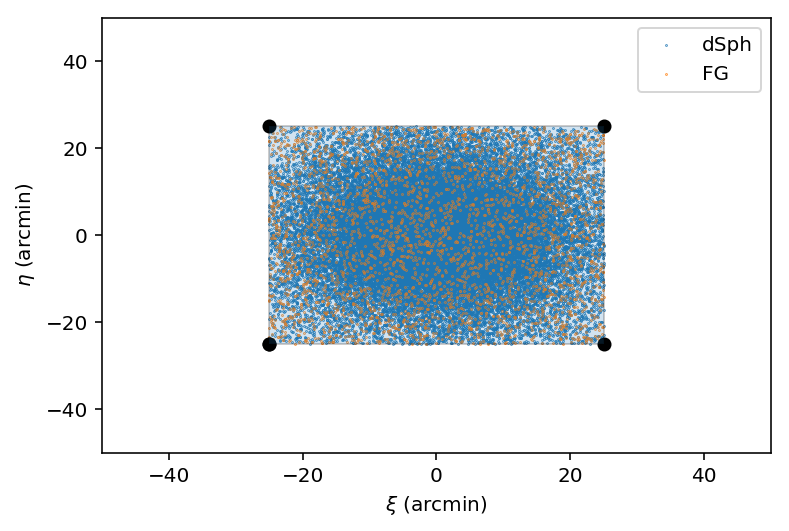

In [15]:
fig = plt.figure()

ax = fig.add_subplot(111)
polyp = PolygonPatch(poly,alpha=0.2,edgecolor='black')
ax.add_patch(polyp)

plt.scatter(dsphcutx,dsphcuty,s=0.1,label='dSph')
plt.scatter(fgcutx,fgcuty,s=0.1,label='FG')


plt.scatter(polyxarr,polyyarr,color='black')
plt.legend()
plt.xlabel(r'$\xi$ (arcmin)')
plt.ylabel(r'$\eta$ (arcmin)')
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.show()